In [1]:
import os
os.chdir("..")

In [2]:
# Are we in parent dir?
assert "visuals" in os.listdir()

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import geodatasets
from collections import Counter
import matplotlib as mpl

In [ ]:
# from struc2vec.src.Helpers import scale_weights

In [6]:
df = pd.read_excel("data/edgelist/UN_full.xlsx")

In [11]:
df_emb3 = pd.read_csv("data/embeddings/v2all_nw500_1000_wl80_vs75_pca3.csv")

In [13]:
df_emb3.columns = ["Country","Embedding"]

In [14]:
df_emb3.groupby("Embedding").size()

Embedding
0    81
1    75
2    70
dtype: int64

In [15]:
code2emb = {k:v for k, v in df_emb3.values}

In [16]:
un_nodes = df["origin"].unique()

In [17]:
country_data = gpd.read_file("visuals/ne_50m_admin_0_countries.geojson")

In [18]:
country_data.head(2)

,scalerank,labelrank,sovereignt,sov_a3,adm0_dif,level,type,admin,adm0_a3,geou_dif,...,region_un,subregion,region_wb,name_len,long_len,abbrev_len,tiny,homepart,featureclass,geometry
0,3,5,Netherlands,NL1,1,2,Country,Aruba,ABW,0,...,Americas,Caribbean,Latin America & Caribbean,5,5,5,4,-99,Admin-0 country,"POLYGON ((-69.89912 12.452, -69.8957 12.423, -..."
1,1,3,Afghanistan,AFG,0,2,Sovereign country,Afghanistan,AFG,0,...,Asia,Southern Asia,South Asia,11,11,4,-99,1,Admin-0 country,"POLYGON ((74.89131 37.23164, 74.84023 37.22505..."


In [19]:
country_data["emb3"] = [str(code2emb[code]) if code in code2emb.keys() else np.nan for code in country_data["adm0_a3"]]
# cmap = ["green" if node in un_nodes else "grey" for node in country_data["adm0_a3"]]

In [20]:
centroid_pos = country_data.centroid.to_crs(country_data.crs)

C:\Users\nikol\AppData\Local\Temp\ipykernel_15572\2356846752.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid_pos = country_data.centroid.to_crs(country_data.crs)


In [21]:
cmap = mpl.colormaps["Set2"]
colors = []
for emb in country_data["emb3"]:
    if type(emb) == str:
        colors.append(cmap(int(emb)))
    else:
        colors.append(cmap(8))



<Axes: >

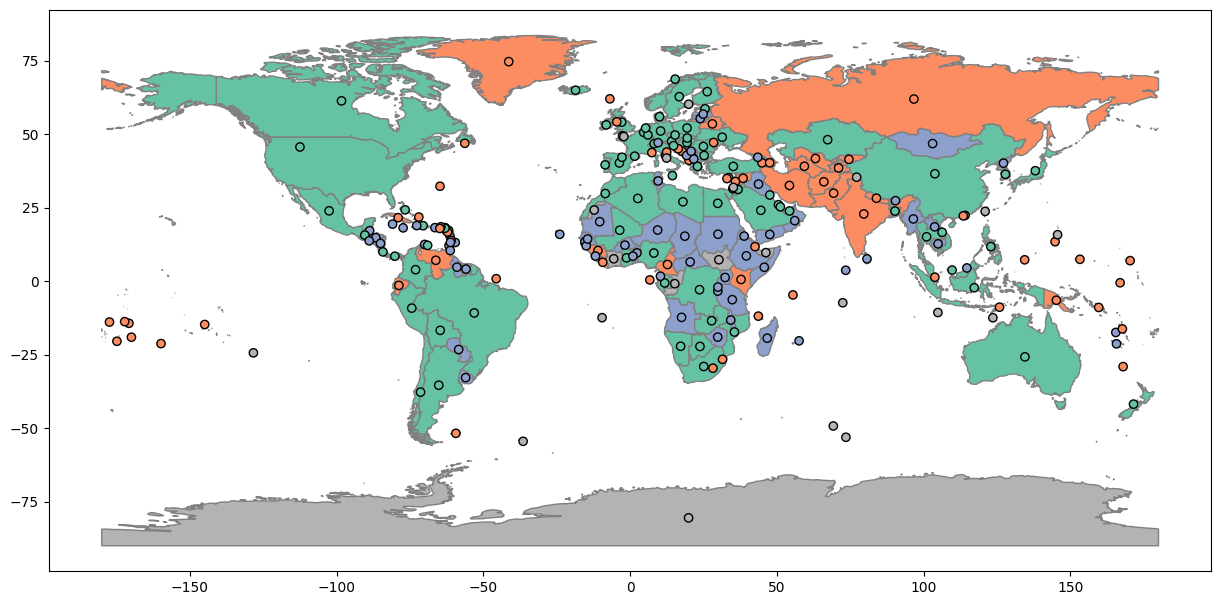

In [22]:
fig, ax = plt.subplots(figsize=(15,15))
country_data.plot(ax=ax, legend=True, color=colors, edgecolor="grey")
centroid_pos.plot(ax=ax, color = colors, edgecolor="black")

In [23]:
country_data.groupby(["emb3","type"]).size()

emb3  type             
0     Country              12
      Sovereign country    68
1     Country               3
      Dependency           15
      Sovereign country    49
2     Country               1
      Dependency            4
      Sovereign country    63
dtype: int64

In [19]:
centroid_coord = [*zip(country_data.centroid.geometry.x, country_data.centroid.geometry.y)]
code2pos = {code:pos for code, pos in zip(country_data["adm0_a3"], centroid_coord)}


C:\Users\nikol\AppData\Local\Temp\ipykernel_12708\872610589.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid_coord = [*zip(country_data.centroid.geometry.x, country_data.centroid.geometry.y)]


In [20]:
G = nx.read_gexf("Graphs/50_directed.gexf")

In [21]:
# Create dictionary of coordinates
G_nodes = list(G.nodes())
for node in G_nodes:
    if node not in code2pos.keys():
        G.remove_node(node)

pos = {}
for node in G.nodes():
    pos[node] = code2pos[node]

In [22]:
cmap_set3 = mpl.colormaps["Set3"]
node2color_set3 = {}
cmap_set2 = mpl.colormaps["Set2"]
node2color_set2 = {}
for node, emb in zip(country_data["adm0_a3"], country_data["emb3"]):
    if type(emb) == str:
        node2color_set3[node] = cmap_set3(int(emb))
        node2color_set2[node] = cmap_set2(int(emb))
    else:
        node2color_set3[node] = cmap_set3(8)
        node2color_set2[node] = cmap_set2(8)

In [23]:
G_cmap = [node2color_set2[node] for node in G.nodes()]

In [24]:
edge_cmap = [node2color_set2[e[0]] for e in G.edges()]

In [25]:
def darken(edge):
    darken_edge = (0.2,0.2,0.2,0.3)
    return tuple([before - darken for before, darken in zip(edge,darken_edge)])

In [26]:
edge_cmap_dark = [darken(edge) for edge in edge_cmap]

In [27]:
weights = np.array([min(round(e[2]["weight"],4),20) for e in G.edges(data=True)])

In [28]:
weights_s = scale_weights(weights, max_scale=1)

In [29]:
legend_dict = {}
for i in range(3):
    legend_dict[i] = cmap_set2(i)

In [30]:
legend_dict

{0: (0.4, 0.7607843137254902, 0.6470588235294118, 1.0),
 1: (0.9882352941176471, 0.5529411764705883, 0.3843137254901961, 1.0),
 2: (0.5529411764705883, 0.6274509803921569, 0.796078431372549, 1.0)}

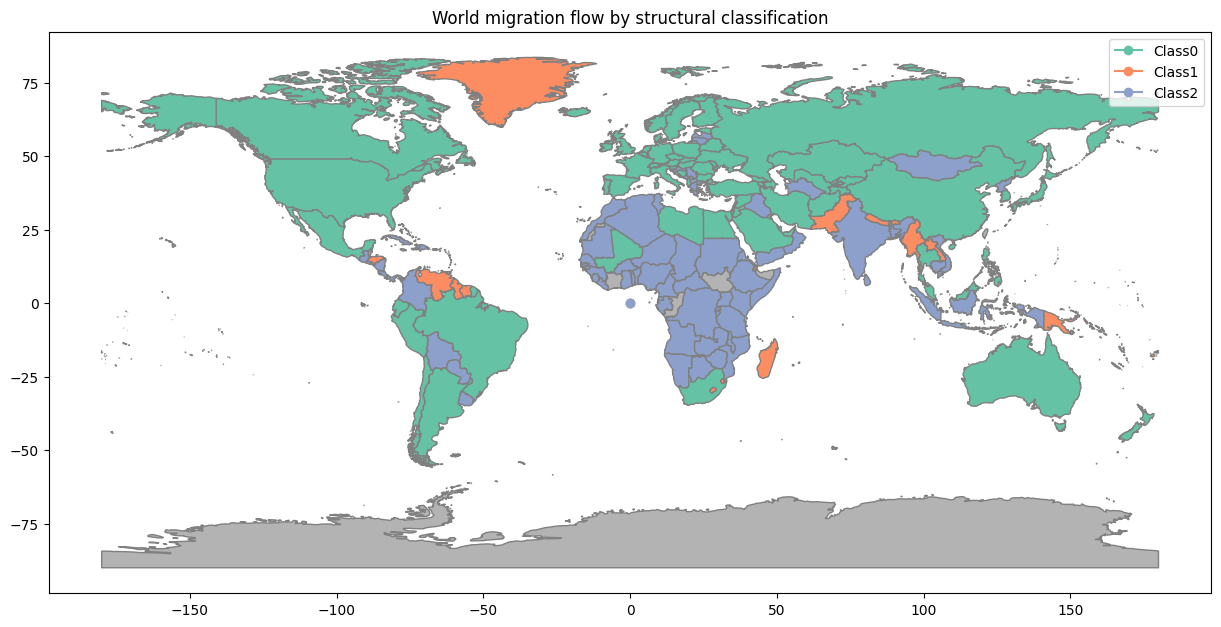

In [31]:
fig, ax = plt.subplots(figsize=(15,15))
country_data.plot(ax=ax, color=colors, edgecolor="grey")

class0, = ax.plot([0],[0], color=legend_dict[0], label="Class0", marker="o")
class1, = ax.plot([0],[0], color=legend_dict[1], label="Class1", marker="o")
class2, = ax.plot([0],[0], color=legend_dict[2], label="Class2", marker="o")
ax.legend(handles=[class0,class1,class2], loc=1)

# nx.draw_networkx(G, 
#                  pos=pos, 
#                  ax=ax, 
#                  with_labels=False,
#                  node_size=25,
#                  node_color=G_cmap,
#                  edgecolors="grey",
#                  width = weights_s,
#                  arrowsize=5,
#                  edge_color=edge_cmap_dark,
#                  )
ax.set_title("World migration flow by structural classification")
plt.savefig("visuals/WorldMap_Class.jpg")
plt.show()